In [1]:
from google.cloud import bigquery
import pandas as pd
import numpy as np
import seaborn as sns
import datetime 
from datetime import date
from datetime import *; from dateutil.relativedelta import *
from datetime import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.9f' % x)
np.set_printoptions(suppress=True)

In [2]:
import pydata_google_auth
credentials = pydata_google_auth.get_user_credentials(
    ['https://www.googleapis.com/auth/bigquery'],
)

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=262006177488-3425ks60hkk80fssi9vpohv88g6q1iqd.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fbigquery&state=ln5nZ4YfvyWkGsQ5RiXZxX1HZXKqGB&access_type=offline


In [3]:
client = bigquery.Client(project = 'etsy-bigquery-adhoc-prod', credentials=credentials)

In [4]:
sql= """
with pubs_to_select as
    (select distinct publisher_id
    from etsy-data-warehouse-prod.static.affiliates_publisher_by_tactic
    where lower(tactic) = 'social creator co' or publisher_id = '946733')
SELECT
    channel_overview_restricted.canonical_region  AS channel_overview_restricted_key_markets,
        (channel_overview_restricted.date ) AS channel_overview_restricted_date_date,
    COALESCE(SUM(( coalesce(channel_overview_restricted.attributed_attr_rev_adjusted, 0) )), 0) AS channel_overview_restricted_attributed_rev_estimated,
     COALESCE(SUM(( coalesce(channel_overview_restricted.attributed_attr_rev_dly, 0)  ) ), 0) AS channel_overview_restricted_attributed_rev_dly_estimated
FROM `etsy-data-warehouse-prod.buyatt_rollups.derived_channel_overview_restricted`  AS channel_overview_restricted
LEFT JOIN `etsy-data-warehouse-prod.buyatt_mart.channel_dimensions`
     AS channel_dimensions ON lower(channel_overview_restricted.utm_campaign) = lower(channel_dimensions.utm_campaign)
      and lower(channel_overview_restricted.utm_medium) = lower(channel_dimensions.utm_medium)
      and lower((initcap(channel_overview_restricted.top_level_channel))) = lower(channel_dimensions.top_channel)
      and lower((initcap(channel_overview_restricted.second_level_channel))) = lower(channel_dimensions.second_channel)
      and lower((initcap(channel_overview_restricted.third_level_channel))) = lower(channel_dimensions.third_channel)
LEFT JOIN pubs_to_select p on channel_overview_restricted.utm_content = p.publisher_id
WHERE ((( channel_overview_restricted.date  ) >= (DATE('2023-01-01')) AND ( channel_overview_restricted.date  ) < (DATE('2023-10-01')))) AND (CASE
WHEN lower(channel_overview_restricted.device) like '%mweb%tablet%'  THEN 'Mobile Web Tablet'
WHEN lower(channel_overview_restricted.device) like '%mweb%handset%'  THEN 'Mobile Web Handset'
WHEN lower(channel_overview_restricted.device)  like '%boe%' and lower(channel_overview_restricted.device) like '%android%'  THEN 'Buy on Etsy - Android'
WHEN lower(channel_overview_restricted.device) like '%boe%' and lower(channel_overview_restricted.device) like '%ios%'  THEN 'Buy on Etsy - iOS'
WHEN lower(channel_overview_restricted.device) like 'desktop'  THEN 'Desktop'
WHEN lower(channel_overview_restricted.device)  like '%soe%' and lower(channel_overview_restricted.device) like '%android%'  THEN 'Sell on Etsy - Android'
WHEN lower(channel_overview_restricted.device) like '%soe%' and lower(channel_overview_restricted.device) like '%ios%'  THEN 'Sell on Etsy - iOS'
ELSE 'Other'
END) IN ('Buy on Etsy - Android', 'Buy on Etsy - iOS') AND (channel_overview_restricted.canonical_region ) IN ('CA', 'GB', 'US') 
AND ((channel_dimensions.reporting_channel_group ) IN ('Dark', 'Direct', 'Non-Paid Social')
or ((channel_dimensions.reporting_channel_group ) IN ('Affiliates') and p.publisher_id is not null))
GROUP BY
    1,
    2
ORDER BY
    1
 """

In [5]:
query_job = client.query(sql)
results = query_job.result()
boe_df = results.to_dataframe()

In [8]:
boe_df['date'] = pd.to_datetime(boe_df['channel_overview_restricted_date_date'])

col_list = []

for i in boe_df.columns:
    
    col_list.append(i.replace('channel_overview_restricted_', 'boe_'))
    
boe_df.columns = col_list

In [9]:
boe_df.head()

,boe_key_markets,boe_date_date,boe_attributed_rev_estimated,boe_attributed_rev_dly_estimated,date
0,CA,2023-07-01,49496.170974398,45480.530243971,2023-07-01
1,CA,2023-05-10,53267.117105364,52910.924230939,2023-05-10
2,CA,2023-06-26,56725.897128383,50651.887993663,2023-06-26
3,CA,2023-07-26,54748.751203134,54517.210222198,2023-07-26
4,CA,2023-03-19,60190.463125711,57187.352857726,2023-03-19


In [13]:
col_list = ['boe_attributed_rev_estimated','boe_attributed_rev_dly_estimated','date']

model_data = pd.concat([boe_df.loc[boe_df.boe_key_markets=='US',col_list].set_index('date'), 
            boe_df.loc[boe_df.boe_key_markets=='CA',col_list].set_index('date'), boe_df.loc[boe_df.boe_key_markets=='GB',col_list].set_index('date')],axis=1)

model_data = model_data.loc[(model_data.index>=pd.Timestamp(2023,3,1)),:]



In [15]:
model_data.corr(method='pearson')

,boe_attributed_rev_estimated,boe_attributed_rev_dly_estimated,boe_attributed_rev_estimated,boe_attributed_rev_dly_estimated,boe_attributed_rev_estimated,boe_attributed_rev_dly_estimated
boe_attributed_rev_estimated,1.000000000,0.610166023,0.612076290,0.308884319,0.347617445,0.284402906
boe_attributed_rev_dly_estimated,0.610166023,1.000000000,0.417119463,0.657160939,0.112925517,0.284904970
boe_attributed_rev_estimated,0.612076290,0.417119463,1.000000000,0.499280911,0.283178743,0.282319274
boe_attributed_rev_dly_estimated,0.308884319,0.657160939,0.499280911,1.000000000,0.028737739,0.307214398
boe_attributed_rev_estimated,0.347617445,0.112925517,0.283178743,0.028737739,1.000000000,0.592924362
boe_attributed_rev_dly_estimated,0.284402906,0.284904970,0.282319274,0.307214398,0.592924362,1.000000000


In [16]:
model_data.head()

,boe_attributed_rev_estimated,boe_attributed_rev_dly_estimated,boe_attributed_rev_estimated,boe_attributed_rev_dly_estimated,boe_attributed_rev_estimated,boe_attributed_rev_dly_estimated
date,,,,,,
2023-03-01,1554296.484239024,1338506.996630669,54937.764111139,50919.473666776,192043.824775403,158879.780978191
2023-03-02,1557988.657520246,1344384.809128402,54974.888155286,51298.531922732,185767.539254178,154300.640637921
2023-03-03,1637319.899345290,1338751.963541576,54906.194461787,50900.482758431,183092.805228872,148118.936880888
2023-03-04,1616775.728658851,1398095.143536811,57812.023667047,52736.422496705,196076.849990303,166162.120121005
2023-03-05,1624889.557309839,1438205.312030371,60020.900803113,55546.979293670,225553.020595553,182222.644328197


In [17]:
model_data.fillna(0).astype(int).sort_values(by='date',ascending=False).head(50)

,boe_attributed_rev_estimated,boe_attributed_rev_dly_estimated,boe_attributed_rev_estimated,boe_attributed_rev_dly_estimated,boe_attributed_rev_estimated,boe_attributed_rev_dly_estimated
date,,,,,,
2023-09-30,1492905,1531539,55783,54243,187881,171236
2023-09-29,1483817,1453929,56074,54355,180878,158753
2023-09-28,1422577,1384569,53539,52215,169199,145603
2023-09-27,1411330,1398229,53483,54231,164277,149497
2023-09-26,1445469,1461353,54159,55076,164204,151083
2023-09-25,1485364,1494109,56217,57087,164771,154002
2023-09-24,1548772,1548341,55462,58263,178815,170304
2023-09-23,1473015,1477540,51668,52705,151313,153954
2023-09-22,1477907,1465012,54119,53684,146177,143855


In [18]:
from causalimpact import CausalImpact
import tensorflow as tf
import tensorflow_probability as tfp

2023-10-08 21:17:30.804012: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
pre_period = [pd.Timestamp(2023,3,1), pd.Timestamp(2023,6,10)]
post_period = [pd.Timestamp(2023,6,11), pd.Timestamp(2023,9,5)]
ci = CausalImpact(model_data.fillna(0).astype(int), pre_period=pre_period, post_period=post_period, model_args={'nseasons': 7})
ci.run()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.47256D-01    |proj g|=  7.36651D-01

At iterate    5    f=  5.05104D-01    |proj g|=  1.06525D-01

At iterate   10    f=  4.96371D-01    |proj g|=  7.85387D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     14     23      1     0     0   3.044D-05   4.963D-01
  F =  0.49634227477165221     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


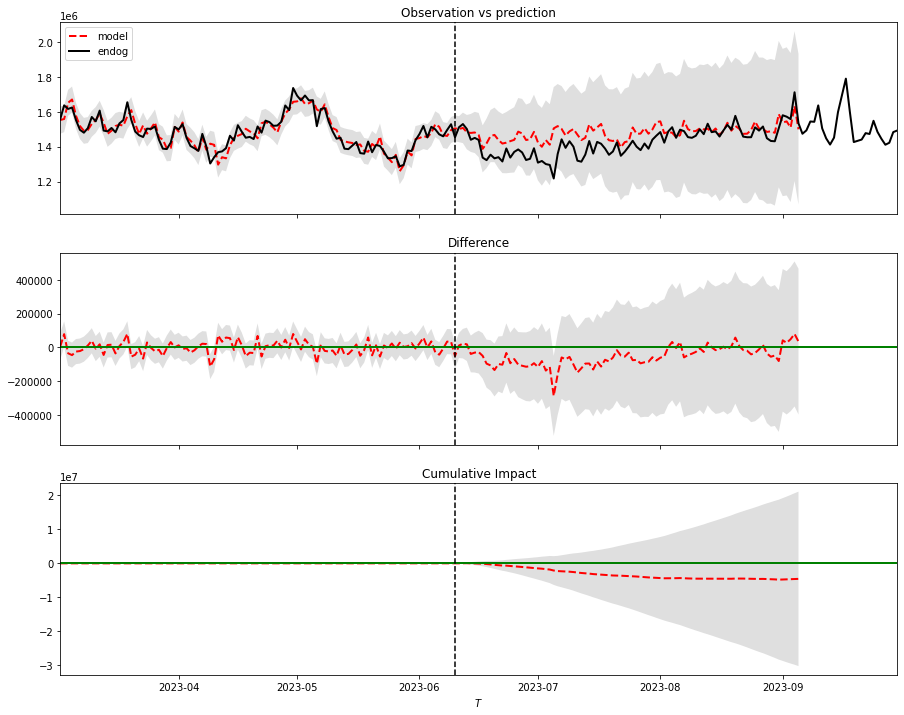

In [20]:
ci.plot()

In [21]:
print(ci.summary())
print(ci.summary('report'))

                                   Average              Cumulative
Actual                             1429425               124360023
Predicted                          1481870               128922705
95% CI                  [1186719, 1777021]  [103244567, 154600843]
                                                                  
Absolute Effect                     -52444                -4562682
95% CI                   [242706, -347595]   [21115455, -30240820]
                                                                  
Relative Effect                      -3.5%                   -3.5%
95% CI                     [16.4%, -23.5%]         [16.4%, -23.5%]
                                                                  
P-value                               0.0%                        
Prob. of Causal Effect              100.0%                        
None
During the post-intervention period, the response             variable had an average value of             approx.
1429425. 

In [ ]:
# TODO: something like this
params = pd.DataFrame(ci.results.results.params).T
params.columns = ci.results.results.param_names 
betas = [column for column in params.columns if column.startswith("beta")]
beta_params = params.loc[:, betas]
# exogenous data for the post period
exog_post = test_result.iloc[test_result.index.get_loc(pd.Timestamp(2023,6,29)):, 1:]

contribution = np.dot(exog_post, beta_params)
contribution = pd.DataFrame(contribution, columns=betas).sum(axis=0)
contribution.plot(kind="barh");

In [ ]:
print(beta_params)